<a href="https://colab.research.google.com/github/AguaClara/Textbook/blob/master/Colab/Prefab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install aguaclara

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.0/112.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.0/305.0 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 44.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 r

In [3]:
import aguaclara as ac
from aguaclara.core.units import unit_registry as u
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Design of support for PVC tank
[PVC properties](https://www.ipolymer.com/pdf/PVC.pdf)
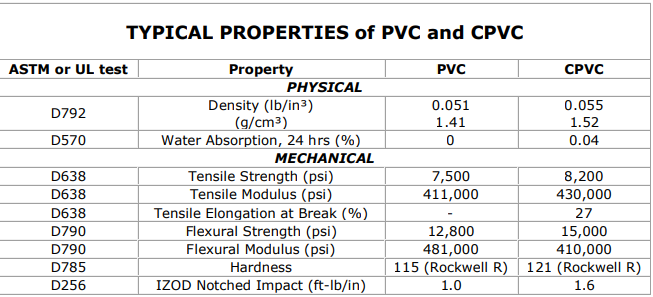
PVC Rigid PVC: 34 - 62 MPa (4930 - 9000 PSI) **

[HDPE properties](http://k-mac-plastics.com/data-sheets/hdpe.htm)

Tensile Modulus	116 - 144 ksi	  0.86 GPa (need to confirm if this is a reasonable value)

The Tensile Strength, Yield	is 21.9 MPa


Equation for deflection of simple beam with uniform loading with sliding support. This will be a conservative analysis because the ends of the PVC sheet continue across the next support and thus there is an additional constraint at the support points. The PVC is not able to rotate at the support points.
[equation source](https://ocw.nthu.edu.tw/ocw/upload/8/258/Chapter_9-98.pdf)

$$\delta = \frac{5qL^4}{384EI}$$

E is the modulus of elasticity, Young's modulus or the tensile modulus and is the material's stiffness

For a rectangle
$$I_x = \frac{b h^3}{12}$$
where b is the width of the rectangle and t is the height. t is thus the thickness, t, of the PVC.

Pressure is force per area or force per length per width
$$ P = \frac{F}{A} = \frac{q}{b}$$

Now combine the previous 3 equations to get deflection, $\delta$ as a function of the pressure and substitute t for h.

$$\delta = \frac{5PbL^4}{384E}\frac{12}{b t^3}$$

As expected b cancels out

$$\delta = \frac{5P L^4}{32E t^3}$$

Pressure is a function of depth
$$ P = \rho g \bar H_W$$

Substituting into the deflection equation we obtain

$$\delta = \frac{5 \rho g \bar H_W L^4}{32E t^3}$$

Solve for the allowed span between supports, W.

$$W = \left(\frac{32E t^3\delta}{5 \rho g \bar H_W }\right)^{1/4} $$

We need an equation that calculates the elevation of the next horizontal support, $H_{W_{i+1}}$ given the elevation of a horizontal support, $H_{W_i}$ and the angle of the wall relative to the horizontal, $\theta$.

$$ \bar H_W = \frac{H_{W_i} + H_{W_{i+1}}}{2}$$

$$ W = \frac{H_{W_{i+1}} - H_{W_i}}{sin(\theta)}$$

We will use a system of 3 equations and iteration to solve at each step. First assume that $H_{W_{i+1}}$ = $H_{W_i}$, solve for W, then calculate a new $H_{W_{i+1}}$ and repeat.

Rearrange previous equation to get $H_{W_{i+1}}$ as a function of W.

$$ H_{W_{i+1}} = W sin(\theta) + H_{W_i} $$

In [15]:
ModulusE = 0.86 * u.GPa
t = 1/4 * u.inch
rho = ac.density_water(20 * u.degC)
HW = 2 * u.m
deflection = 2 * u.mm
Temperature = 20 * u.degC

def spanW(ModulusE, HW, t, deflection, Temperature):
  rho = ac.density_water(Temperature)
  return ((32 * ModulusE * t**3 * deflection)/(5 * rho * u.gravity * HW))**(1/4)

print(spanW(ModulusE, HW, t, deflection, Temperature).to(u.m) )

0.1095 meter


This suggests that the tank will require an extensive exoskeleton or webbing that ties both sides of the tanks together regardless of the thickness of the HDPE. The HDPE simply is not nearly strong enough. If we use internal webbing, then we need to assess the minimum spacing required for fabrication and maintenance in the tanks. If the internal webbing has to be very closely spaced, then it raises questions about spacing requirements for access during fabrication and maintenance.

The goals of modularity and the high cost and labor requirements of building an exoskeleton suggest that we should transition to optimal shapes for water tanks (cylinders). The cylindrical walls would be in pure tension and thus we could minimum the amount of wall material required and could eliminate the exoskeleton.



# Wall thickness given hoop stress

The pressure as a function of depth is

$$P = \rho g H_W$$

where $H_W$ is the depth of water and $\rho$ is the fluid density.

The hoop stress $σ$ is given by

$$\sigma = \frac{Pr}{2t}$$

*   P is the internal pressure $P = \rho g H_W$
*   t is the wall thickness
*   r is the mean radius of the cylinder
*   $σ$ is the hoop stress.

In terms of water depth the hoop stress is

$$\sigma = \frac{\rho g H_W r}{2t}$$

We need to know the safe working stress for HDPE.
[Nuclear Regulatory Commision](https://www.nrc.gov/docs/ML1427/ML14273A451.pdf) gives a value of 800 psi (5.5 MPa) for a 50 year life for HDPE.

The minimum tank wall thickness (by rearranging) is thus

$$t_{min} = \frac{\rho g H_W r}{2\sigma_{max}}$$

where $\sigma_{max}$ is the safe working stress for HDPE.

In [27]:
r = 2 * u.m
WorkingStress = 800 * u.psi
print(WorkingStress.to(u.MPa))
def hoopStress(HW, t, Temperature):
  rho = ac.density_water(Temperature)
  return rho * u.gravity * HW * r / (2 * t)
print(hoopStress(HW, 0.5 * u.inch, Temperature).to(u.MPa))

def tminHoopStress(WorkingStress, HW, Temperature):
  rho = ac.density_water(Temperature)
  return rho * u.gravity * HW * r / (2 *WorkingStress)

print(tminHoopStress(WorkingStress, HW, Temperature).to(u.inch))

5.516 megapascal
1.542 megapascal
0.1397 inch


# Cost Analysis

Cost for a flocculator

Next steps would be to design the steel or aluminum beam that would be pressing directly against the PVC. This beam would also have a uniform load and we would want to calculate the size and optimal span.
https://en.wikipedia.org/wiki/List_of_second_moments_of_area

$$I_x = \frac{bh^3-b_1h_1^3}{12}$$
https://www.engineeringtoolbox.com/young-modulus-d_417.html
$$E_{Al} = 69 GPa$$

let t = thickness of the wall of the rectangular tube

$$h_1 = h - 2t$$
$$b_1 = b - 2t$$

$$I_x = \frac{bh^3-(b - 2t)(h - 2t)^3}{12}$$

Solve for b = h =w for case when $I_x$ is given.

$$I_x = \frac{w^4-(w - 2t)^4}{12}$$

$$\delta = \frac{5qL^4}{384EI}$$

E is the modulus of elasticity, Young's modulus or the tensile modulus and is the material's stiffness.

Pressure is force per area or force per length per width, the space between horizontal tubes

$$ P = \frac{F}{A} = \frac{q}{W}$$

Now combine the previous 3 equations to get deflection, $\delta$ as a function of the pressure

$$\delta = \frac{5PWL^4}{384EI}$$

Pressure is a function of depth
$$ P = \rho g h_w$$

Substituting into the deflection equation we obtain

$$\delta = \frac{5\rho g h_wWL^4}{384EI}$$

Solve for the allowed span between supports, L.

$$L = \left( \frac{384EI\delta}{5\rho g h_wW} \right)^{1/4} $$

In [6]:
AlE=69 *u.GPa
print(AlE)
deflection = 1 * u.mm
b=1*u.inch
h=1*u.inch
t=1/8*u.inch
hw = 2*u.m
spantube = (32 * AlE * deflection * (b*h**3 - ((b-2*t)*(h-2*t)**3))/(5 * rho * u.gravity * hw * spanPVCW))**(1/4)
print(spantube.to(u.m))

69 gigapascal


NameError: name 'spanPVCW' is not defined

next step is the columns that form a cradle. Find an equation that can be used to estimate the tube dimensions. We'll assume it is square.